-----------------------------------------
organic
-----------------------------------------
shape angMomTot (3,)
k:  [0.9515281  0.30598536 0.0311003 ]
j:  [0.32157258995097276, 1, 0]
i:  [ 0.0311003 -0.010001  -0.8531316]
K_tot:  28501792515.963
R: [0.00042708 0.00038965 0.00055176 0.00043276 0.00039526 0.00016764
 0.00040092 0.00039415 0.00032458 0.0001919  0.00072504 0.00108752
 0.00077522 0.00060149 0.000587   0.00035194 0.00018025 0.00045061
 0.00045383 0.00049038 0.00037636 0.00024091 0.00057759 0.00054225
 0.00082936 0.0002818  0.00051389 0.00024078 0.00120068 0.00017892
 0.00057822 0.0005728  0.00031528 0.00043619]
Krot_co 5543794351.718721
K_co 0.1945068664931796
-------------------------------------------------
shape angMomTot (3,)
k:  [ 0.65267355 -0.15264495  0.74210293]
j:  [-0.2338764076937788, 1, 0]
i:  [ 0.74210293  0.17356037 -0.6169735 ]
K_tot:  118196994376.26611
R: [3.21167859e-03 1.11177266e-03 2.10258437e-04 1.32340313e-03
 3.38471988e-03 2.09387382e-03 2.21653310

R: [0.00656966 0.00836907 0.00696449 ... 0.00034462 0.00036943 0.00036078]
Krot_co 65664869790766.1
K_co 0.3860879159492912
-------------------------------------------------
shape angMomTot (3,)
k:  [ 0.57311824 -0.02407833 -0.81911886]
j:  [-0.04201284534483726, 1, 0]
i:  [-0.81911886 -0.03441351 -0.57210665]
K_tot:  642157474899498.2
R: [0.00025157 0.00026473 0.00026107 ... 0.00124515 0.00136407 0.0011988 ]
Krot_co 419221585739611.7
K_co 0.6528329921024785
-------------------------------------------------
shape angMomTot (3,)
k:  [ 0.33754953  0.3880109  -0.85761755]
j:  [1.1494932410732626, 1, 0]
i:  [-0.85761755  0.98582557  0.10846638]
K_tot:  1427247074461612.0
R: [0.00048397 0.00049443 0.00049196 ... 0.00030401 0.0003428  0.00035637]
Krot_co 985285497565157.2
K_co 0.6903398263659626
-------------------------------------------------
shape angMomTot (3,)
k:  [ 0.54525853  0.29730157 -0.78377606]
j:  [0.545248818335682, 1, 0]
i:  [-0.78377606  0.42735297 -0.3831552 ]
K_tot:  943598

shape angMomTot (3,)
k:  [ 0.21321469 -0.89920757  0.38205397]
j:  [-4.217380904197133, 1, 0]
i:  [0.38205397 1.61126712 3.57908615]
K_tot:  1231309213805.9326
R: [0.00324157 0.00111442 0.00781922 0.00557621 0.00626053 0.00382357
 0.00368048 0.00600281 0.00687726 0.00820489 0.00323278 0.00651564
 0.00565344 0.00516786 0.00230073 0.00401221 0.00405793 0.0041554
 0.00353609 0.00336564 0.00440774 0.00407747 0.00378392 0.02267179
 0.04317852 0.03380664 0.0318231  0.03009199 0.02978291 0.03005489
 0.02882495 0.02777024 0.02790195 0.02612469 0.02465089 0.023716
 0.02917884 0.02979533 0.03041012 0.03886501 0.02766323 0.02121417
 0.00741762 0.00479001 0.00550316 0.00243829 0.00132168 0.00172453
 0.00089036 0.00519724 0.00247707 0.00297439 0.00089679 0.00061871
 0.00170457 0.00799946 0.00682456 0.00954105 0.00694188 0.00279125
 0.00530345 0.00194012 0.00313421 0.00578095 0.00192748 0.00236585
 0.00267914 0.00814083 0.01187086 0.01850062 0.02833576 0.02850794
 0.02767904 0.02939954 0.03515168 0.

Krot_co 15894245156781.168
K_co 0.45221523167301175
-------------------------------------------------
shape angMomTot (3,)
k:  [ 0.42571865  0.71234153 -0.55797238]
j:  [1.673268310178513, 1, 0]
i:  [-0.55797238  0.9336375   0.76621985]
K_tot:  40343164627109.74
R: [0.01139544 0.01271216 0.00938388 ... 0.02107542 0.01820099 0.02585605]
Krot_co 18633430200263.95
K_co 0.4618732906179275
-------------------------------------------------
shape angMomTot (3,)
k:  [ 0.40161615  0.73286378 -0.549195  ]
j:  [1.824786601485083, 1, 0]
i:  [-0.549195    1.00216368  0.93570385]
K_tot:  54328413320479.88
R: [0.01464873 0.04907132 0.03896574 ... 0.01741111 0.01635058 0.01553329]
Krot_co 25105764157425.61
K_co 0.46211112423490613
-------------------------------------------------
shape angMomTot (3,)
k:  [ 0.24270048  0.89668965 -0.37019475]
j:  [3.694634863253896, 1, 0]
i:  [-0.37019475  1.36773443  3.07024036]
K_tot:  208729602305494.06
R: [0.08839773 0.08128243 0.10406517 ... 0.02070677 0.02062407 

Krot_co 80473974413480.19
K_co 0.2950621728289556
-------------------------------------------------
shape angMomTot (3,)
k:  [ 0.79237581 -0.46708601  0.39239168]
j:  [-0.5894753507992935, 1, 0]
i:  [ 0.39239168  0.23130522 -0.51704012]
K_tot:  391492925014312.25
R: [0.00051648 0.00047162 0.0004767  ... 0.00711157 0.00736094 0.00754744]
Krot_co 178567197490908.16
K_co 0.4561185811579611
-------------------------------------------------
shape angMomTot (3,)
k:  [ 0.89565589 -0.37190899  0.2438939 ]
j:  [-0.41523646917420265, 1, 0]
i:  [ 0.2438939   0.10127364 -0.74122571]
K_tot:  714170731959190.5
R: [0.0001357  0.0001391  0.00013692 ... 0.002624   0.00273219 0.00279405]
Krot_co 410386243443672.2
K_co 0.5746332425551187
-------------------------------------------------
shape angMomTot (3,)
k:  [ 0.91713541 -0.3927104  -0.06812614]
j:  [-0.42819239020141164, 1, 0]
i:  [-0.06812614 -0.0291711  -0.74897981]
K_tot:  629429278927283.8
R: [0.00375656 0.00348283 0.00433403 ... 0.00270132 0.003

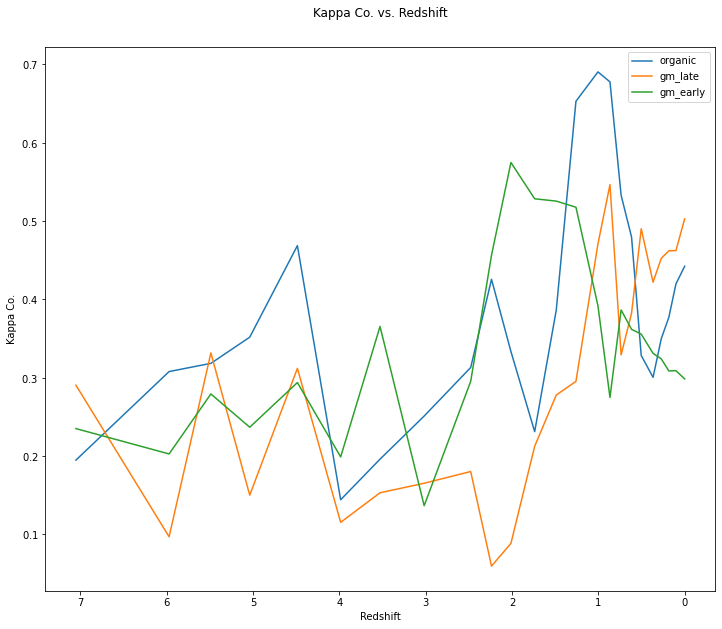

In [10]:
import h5py
import matplotlib.pyplot as plt
from os import listdir
from mpl_toolkits import mplot3d
import matplotlib.gridspec as gridspec
import numpy as np
import re

axisScale = 0.03
datasets = ['organic', 'gm_late', 'gm_early']

datasetNo = 0

# define storage arrays and reshape to hold all three galaxy type data
redshifts = np.array(range(3*24), dtype=float)
redshifts.shape = (3, 24)
kco_s = np.array(range(3*24), dtype=float)
kco_s.shape = (3, 24)

for dataset in datasets:
    print('-----------------------------------------')
    print(dataset)
    print('-----------------------------------------')
    
    files = listdir('data/' + dataset)

    count = 0
    
    for file in files:
    #if 1==1:



        #file = 'star_particles_015_z002p012.hdf5'
        #file = 'star_particles_028_z000p000.hdf5'
        
        # get redshift from the filename
        m = re.search('(z[0-9])\w+', file)
        s = m.group(0).replace('z', '')
        s = s.replace('p', '.')
        redshift = float(s)
        
        # load data for a particular galaxy at a particular redshift
        f = h5py.File('data/' + dataset + '/' + file,'r')

        # extract data from the file
        ds_c = f['Coordinates']
        ds_v = f['Velocity']
        ds_m = f['Mass']
    

        # Calculate the resultant angular momentum vectors r
        # r contains the angular momentum vectors for each particle per redshift era
        r0 = np.cross(ds_c, ds_v)
        r = np.transpose(np.multiply(ds_m, np.transpose(r0)))
        #print ("shape r", np.shape(r))
        
        # Calculate the total angular momentum vector by summing the vectors (per redshift epoch)
        angMomTot = np.sum(r, axis=0)
        print ("shape angMomTot", np.shape(angMomTot)) 
        
        # Calculate the magnitude of the total angular momentum vector for each redshift epoch
        # We use this to normalise the angular momentum to a unit vector for scaling during the transform
        magnitude = np.linalg.norm(angMomTot)
        
        # Alternative way of calculating the magnitude
        # magnitude2 = np.sqrt(angMomTot[0]**2 + angMomTot[1]**2 + angMomTot[2]**2)
        
        # Calculate the scale factor by working out the angular momentum 
        unitVect_z = angMomTot / magnitude
        #print ("unitVect_z", unitVect_z)
        #print ("np.linalg.norm(unitVect_z)", np.linalg.norm(unitVect_z))
        
        
        # the angular momentum's vector's (unitVect_z) direction is directly out of the plane of the galaxy
        # unitVect_z = k, but j = [-k2/k1, 1, 0], so
        
        k = unitVect_z
        print ("k: ", k)
        
        j = [k[1]/k[0], 1, 0]
        print ("j: ", j)
        
        i = np.cross(j, unitVect_z)
        print ("i: ", i)
        
        
        # transform co-ordinates
        dsc_x_trsfrm = np.dot(ds_c, i)
        #print ("dsc_x_trsfrm", dsc_x_trsfrm)
        #print ("dsc_x_trsfrm shape", np.shape(dsc_x_trsfrm))
        
        dsc_y_trsfrm = np.dot(ds_c, j)
        #print ("dsc_y_trsfrm", dsc_y_trsfrm)
        #print ("dsc_y_trsfrm shape", np.shape(dsc_y_trsfrm))
        
        dsc_z_trsfrm = np.dot(ds_c, k)
        #print ("dsc_z_trsfrm", dsc_z_trsfrm)
        #print ("dsc_z_trsfrm shape", np.shape(dsc_z_trsfrm))
        
        #dsc_trans = list(zip(dsc_x_trsfrm, dsc_y_trsfrm, dsc_z_trsfrm))
        dsc_trans = np.transpose(np.array([dsc_x_trsfrm, dsc_y_trsfrm, dsc_z_trsfrm]))
        
        #transform velocities
        dsv_x_trsfrm = np.dot(ds_v, i)
        #print ("dsv_x_trsfrm", dsv_x_trsfrm)
        #print ("dsv_x_trsfrm shape", np.shape(dsv_x_trsfrm))
        
        dsv_y_trsfrm = np.dot(ds_v, j)
        #print ("dsv_y_trsfrm", dsv_y_trsfrm)
        #print ("dsv_y_trsfrm shape", np.shape(dsv_y_trsfrm))
        
        dsv_z_trsfrm = np.dot(ds_v, k)
        #print ("dsv_z_trsfrm", dsv_z_trsfrm)
        #print ("dsv_z_trsfrm shape", np.shape(dsv_z_trsfrm))
        
        dsv_trans = np.transpose(np.array([dsv_x_trsfrm, dsv_y_trsfrm, dsv_z_trsfrm]))
        
        # Get transposed velocity in the x-y plane only
        ##dsv_trans = np.transpose(np.array([dsv_x_trsfrm, dsv_y_trsfrm, dsv_z_trsfrm]))
        
        #print results
        #print ("dsc_trans", dsc_trans)
        #print ("dsc_trans shape", np.shape(dsc_trans))
        
        #print ("dsc_trans[0,x]")
        #print (dsc_trans[0,0])
        #print ("dsc_trans[0,y]")
        #print (dsc_trans[0,1])
        #print ("dsc_trans[0,z]")
        #print (dsc_trans[0,2])        
        
        #print ("dsv_trans", dsv_trans)
        #print ("dsv_trans shape", np.shape(dsv_trans))
        
        #print ("dsv_trans[0,x]")
        #print (dsv_trans[0,0])
        #print ("dsv_trans[0,y]")
        #print (dsv_trans[0,1])
        #print ("dsv_trans[0,z]")
        #print (dsv_trans[0,2])  
       
        # Calculate KE of transformed particles
        # Get magnitudes of the vectors
        vel_magnitude = np.linalg.norm(dsv_trans, axis=1)

        # Calculate kinetic energy for all star particles
        K_tot = np.sum(0.5 * np.array(ds_m) * np.square(vel_magnitude))
        print ('K_tot: ', K_tot)
        ##specificKe = np.sum(0.5 * np.square(vel_magnitude))


        
        # Calculate R, the distance from the centre in the x-y plane
        R = np.sqrt(np.square(dsc_x_trsfrm) + np.square(dsc_y_trsfrm))
        #print ('R shape', np.shape(R))
        print ('R:', R)
               
        # Calculate momentum 
        res = np.cross(dsc_trans, dsv_trans)
        momentum = np.transpose(np.multiply(ds_m, np.transpose(res)))
        ##momentum = np.multiply(ds_m, res)
        #print('Momentum shape:', np.shape(momentum))
        #print('Momentum',momentum)
        
        # Extract L_z
        L_z = np.array(momentum[:,2])
        #print('L_z:', L_z)    
        
        Krot_co = 0
        for n in range(0, len(ds_m)):
            if L_z[n] < 0 or R[n] == 0:
                continue
            Krot_co = Krot_co + (0.5 * ds_m[n] * np.square(L_z[n] / (ds_m[n]*R[n]) ))
        
        print('Krot_co',Krot_co)
        
        K_co = Krot_co / K_tot
        
        print('K_co',K_co)
        
        redshifts[datasetNo,count] = redshift
        kco_s[datasetNo,count] = K_co
              
        count = count + 1
        print ('-------------------------------------------------')
        
    # Next galaxy
    datasetNo = datasetNo + 1

plt.figure(figsize = (12,10))
plt.title('Kappa Co. vs. Redshift', pad=30)
plt.xlabel('Redshift')
plt.ylabel('Kappa Co.')
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
#plt.semilogy()
for i in range(0,3):
   plt.plot(redshifts[i,0:], kco_s[i,0:])
plt.legend(['organic', 'gm_late', 'gm_early'])
plt.gca().invert_xaxis()
plt.show()      